# GeoJupyter demo

## Today: [🔗JupyterGIS](https://jupytergis.readthedocs.io/)

JupyterGIS is a **real-time collaborative** Geographical Information System (GIS) environment in JupyterLab.

You can [🔗try it right now in JupyterLite](https://jupytergis.readthedocs.io/en/latest/lite/lab/)!

Let's explore some functionality together (based on [🔗Carl Boettiger](https://ourenvironment.berkeley.edu/people/carl-boettiger)'s [🔗ESPM-288 course](https://espm-288.carlboettiger.info/)). We'll explore the question: are neighborhoods that were highly-rated (A) under the disciminatory 1930s practice of [🔗redlining](https://en.wikipedia.org/wiki/Redlining) are greener today than neighborhoods graded D?

:::{warning}
Please be aware that JupyterGIS is a young project and it's likely you'll run in to bugs.
We encourage you to try to break it and [report issues you find on GitHub](https://github.com/geojupyter/jupytergis/issues)!
:::

### Constants

Some variables that will be used throughout the Notebook.

In [4]:
from pathlib import Path

DATA_DIR = Path().cwd() / "data"
INEQUALITY_GEOJSON_FILE = DATA_DIR / "redlining_newhaven_ct.geojson"
NDVI_GEOTIFF_FILE = DATA_DIR / "ndvi.tif"
INEQUALITY_NDVI_GEOJSON_FILE = DATA_DIR / "redlining_ndvi_newhaven_ct.geojson"

# We need the data directory to exist, IPython lets us do it easily
!mkdir -p $DATA_DIR

### Set up a JupyterGIS project

We can build a JupyterGIS project from scratch in Python. Let's start by adding an OpenStreetMap basemap and displaying the widget in a side panel.

In [2]:
from jupytergis import GISDocument

jgis_project = GISDocument("new_haven_redlining_analysis.jGIS")
jgis_project.add_raster_layer(
    url="https://a.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}@2x.png",
    name="Basemap",
)

# Open this in a new panel on the right
jgis_project.sidecar()

You should see a map on the right with a simple dark basemap.

Try closing or shrinking the file browser on the left to make more room!

### Get historical redlining data

We're using [🔗DuckDB](https://duckdb.org/) to connect to a [🔗geopackage](https://www.geopackage.org/) dataset containing data about redlining, and filter that data to select residential neighborhoods in New Haven, Connecticut, USA.

In [5]:
import ibis
from ibis import _


con = ibis.duckdb.connect(extensions=["spatial"])

redlines = (
    con
    .read_geo("/vsicurl/http://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg")
    .filter(_.city == "New Haven", _.residential)
    # Add a numeric grade to provide a scalar value for JupyterGIS symbology
    # "A" is ascii value 65, so we subtract 64 to start with 1.
    # TODO: Do this in Pandas not DuckDB! (.astype('category').cat.codes)
    # Or: https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html#pandas.Series.map
    .mutate(numeric_grade=_.grade.ascii_str() - 64)
)

new_haven_redlining =  redlines.execute().set_crs("EPSG:4326")
new_haven_bbox = new_haven_redlining.total_bounds

new_haven_redlining.to_file(INEQUALITY_GEOJSON_FILE, engine="fiona")
new_haven_redlining.head()

,area_id,city,state,city_survey,category,grade,label,residential,commercial,industrial,fill,geom,numeric_grade
0,3569,New Haven,CT,True,Best,A,A1,True,False,False,#76a865,"MULTIPOLYGON (((-72.9 41.36885, -72.90325 41.3...",1
1,3568,New Haven,CT,True,Best,A,A2,True,False,False,#76a865,"MULTIPOLYGON (((-72.89401 41.36331, -72.89256 ...",1
2,3566,New Haven,CT,True,Best,A,A3,True,False,False,#76a865,"MULTIPOLYGON (((-72.90981 41.35949, -72.90284 ...",1
3,3567,New Haven,CT,True,Best,A,A4,True,False,False,#76a865,"MULTIPOLYGON (((-72.90284 41.35795, -72.8999 4...",1
4,3564,New Haven,CT,True,Best,A,A5,True,False,False,#76a865,"MULTIPOLYGON (((-72.89801 41.3493, -72.89883 4...",1


You should notice that 5 rows of data are shown above. They're all residential neighborhoods with `grade` "A", meaning the neighborhoods were mostly occupied by white citizens. This grade was used to discriminate against non-white people seeking home loans.

There is a `fill` column containing a hexadecimal color code, and a `geom` column containing polygon shapes.

There's an additional `numeric_grade` column which contains a number-encoded version of the `grade` column.

#### Explore the data

Let's explore the data a little bit in JupyterGIS. First, add the data to the map:

In [14]:
# We'll suppress the output value with a `;` at the end, but you can 
# capture that (a layer ID) as a value if you want to modify it later
jgis_project.add_geojson_layer(
    path=INEQUALITY_GEOJSON_FILE,
    name="New Haven neighborhood redlining",
);

You should notice that the layers panel on the left of the JupyterGIS UI contains a new layer: "New Haven neighborhood redlining".

:::{important} In the JupyterGIS UI...
After running the cell above, **right-click the "New Haven neighborhood redlining" layer** in the JupyterGIS interface, and **select "Zoom to layer"**. 

Now, with the "New Haven neighborhood redlining" layer selected, **click the `i` (identify) icon in the toolbar** at the top of the JupyterGIS interface.

Select some neighborhoods and view their "Grade" and "Category" attributes.
:::

#### Configure symbology

This dataset has a "fill" attribute which determines which color each polygon should be rendered with based on its grade.

::::::{important} In the JupyterGIS UI...

:::{warning} Beware of bugs!
The symbology menu is a bit fragile. Stick to the instructions and you'll be OK! If anything goes wrong, try removing the layer (right-click) and re-adding it.
:::

Right-click the layer "New Haven neighborhood redlining" and select **Edit Symbology**. This symbology mode renders each feature based on a data attribute containing a color.

**Select "Canonical"** from the "Render Type" menu. The "Value" field should contain the "fill" attribute already, so **click OK**.

You should notice that the neighborhoods ranked "A" are green, "B" are blue, "C" are yellow, and "D" are red.
::::::

### Calculate NDVI

We're going to calculate NDVI ([🔗 Normalized Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)) from Sentinel-2 data.

#### Open Sentinel-2 data

We are using a [🔗STAC catalog](https://stacspec.org/en) to locate the data files we're interested in (covering New Haven during Summer 2024, with <20% cloud cover) and opening them as an Xarray DataSet.

In [8]:
import odc.stac
from pystac_client import Client

items = Client.open(
    "https://earth-search.aws.element84.com/v1"
).search(
    collections = ['sentinel-2-l2a'],
    bbox=new_haven_bbox,
    datetime = "2024-06-01/2024-09-01",
    query={"eo:cloud_cover": {"lt": 20}}
).item_collection()

data = odc.stac.load(
    items,
    bands=["nir08", "red"],
    bbox=new_haven_bbox,
    resolution=10,
    groupby="solar_day",
    chunks = {},
)
data

<xarray.Dataset> Size: 32MB
Dimensions:      (y: 1627, x: 1220, time: 4)
Coordinates:
  * y            (y) float64 13kB 4.583e+06 4.583e+06 ... 4.566e+06 4.566e+06
  * x            (x) float64 10kB 6.678e+05 6.678e+05 ... 6.8e+05 6.8e+05
  * time         (time) datetime64[ns] 32B 2024-06-15T15:51:53.600000 ... 202...
    spatial_ref  int32 4B 32618
Data variables:
    nir08        (time, y, x) uint16 16MB dask.array<chunksize=(1, 1627, 1220), meta=np.ndarray>
    red          (time, y, x) uint16 16MB dask.array<chunksize=(1, 1627, 1220), meta=np.ndarray>

You should notice that the two requested data variables (near-infrared and red) are present in the xarray DataSet.

#### Do the NDVI calculation

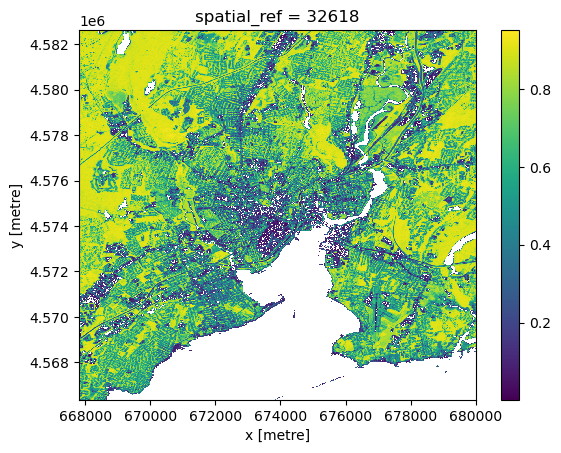

In [12]:
ndvi = (
    (data.nir08 - data.red) / (data.red + data.nir08)
).median(
    "time",
    keep_attrs=True,
).where(
    lambda ndvi: ndvi < 1
).compute()

ndvi.plot.imshow();

#### Save the NDVI raster to file

In [15]:
import rioxarray

# TODO: Use jupytergis_tiler
ndvi.rio.reproject(
    "EPSG:4326",
).rio.to_raster(
    raster_path=NDVI_GEOTIFF_FILE, 
    driver="COG",  # Cloud-Optimized GeoTIFF
)

#### Explore the data

Let's explore the data in JupyterGIS again.
This time, we'll add the NDVI data as a layer with the GUI.

::::::{important} In the JupyterGIS UI...

:::{warning} Beware of bugs!
The symbology menu is a bit fragile. You may see some things that look a little weird, but stick to the instructions and you'll be OK! If anything goes wrong, try removing the layer (right-click) and re-adding it.
:::

If the "identify" tool is still active, click the `i` icon in the toolbar again to disable it.

Now, **click the `+` icon in the toolbar** to open the new layer interface.
**Select "Add Raster Layer", then "New GeoTiff Layer"**.

**Select "Browse Server Files"** and then **navigate to `ndvi.tif` in the module 6 data directory** (`workshop-open-source-geospatial/modules/06-geojupyter/data/ndvi.tif`).

Click **Select**.

**Set the "Min" field to `0` and "Max" to `1`**.

**Uncheck "Normalize"**.

Scroll down to **input the layer name as "NDVI"**.

**Click "OK"** to add the layer to the map.

You should notice that the data doesn't look right -- it's entirely black-and-white.

We need to set up the symbology now.

Finally, **right-click the "NDVI" layer** and **select "Edit Symbology"**. The symbology menu may take a moment to load. Be patient! **Select "Classify" then click "OK".**

The brighter areas have a higher NDVI value, and the darker areas have a lower one.

We can use the identify tool (`i` icon in the toolbar) to explore the raw values.

You might notice that the colored polygons show through in areas where the NDVI is `NaN`. You can hide that layer with the 👁️ icon in the JupyterGIS layers panel.
::::::

### Zonal Statistics: Calculating mean NDVI for each New Haven neighborhood

To find out whether neighborhoods graded "A" are greener than neighborhoods graded "D", we'll calculate the mean NDVI for each neighborhood using [🔗exactextract](https://isciences.github.io/exactextract/background.html), which is known for its capability to include fractional grid cells in its calculation (as opposed to other tools, where a cell is binary, either inside or outside the polygon).

In [16]:
from exactextract import exact_extract

new_haven_redlining_and_ndvi = exact_extract(
    NDVI_GEOTIFF_FILE,
    new_haven_redlining,
    "mean_ndvi=mean",  # Give the column a human-readable name!
    include_geom = True,
    include_cols=["label", "grade", "city", "fill"],
    output="pandas",
)

new_haven_redlining_and_ndvi.set_crs(
    "EPSG:4326"
).to_file(INEQUALITY_NDVI_GEOJSON_FILE, engine="fiona")

new_haven_redlining_and_ndvi.head()

,label,grade,city,fill,mean_ndvi,geometry
0,A1,A,New Haven,#76a865,0.709624,"MULTIPOLYGON (((-72.9 41.36885, -72.90325 41.3..."
1,A2,A,New Haven,#76a865,0.761685,"MULTIPOLYGON (((-72.89401 41.36331, -72.89256 ..."
2,A3,A,New Haven,#76a865,0.665130,"MULTIPOLYGON (((-72.90981 41.35949, -72.90284 ..."
3,A4,A,New Haven,#76a865,0.751388,"MULTIPOLYGON (((-72.90284 41.35795, -72.8999 4..."
4,A5,A,New Haven,#76a865,0.742981,"MULTIPOLYGON (((-72.89801 41.3493, -72.89883 4..."


You should notice that the dataset now includes a `mean_ndvi` column with the results of our zonal statistics calculation! 🎉

In [17]:
jgis_project.add_geojson_layer(
    path=INEQUALITY_NDVI_GEOJSON_FILE,
    name="New Haven neighborhood redlining w/ NDVI",
);

Notice that there are now two copies of the New Haven neighborhoods polygon layer. The new one is titled the same as the old one with "w/ NDVI" appended.

::::::{important} In the JupyterGIS UI...

:::{warning} Beware of bugs!
If the new redlining w/ NDVI layer disappears, remove it from the map by right-clicking it in the JupyterGIS layers panel and selecting "Remove Layer". Then re-run the cell above.
:::

Temporarily hide the "NDVI" raster layer with the 👁️ icon in the JupyterGIS layers panel so you can more clearly see the new layer.

Hide the "old" copy of the redlining layer ("New Haven neighborhood redlining") with the 👁️ icon in the JupyterGIS layers panel.
:::::::



### Visualizing correlation

Now that we have neighborhood grades and mean NDVI for each neighborhood, how do we visualize any potential correlation?

TODO: Bivariate choropleth?

TODO: ?

## Future

### Story maps / "scrolly telling"

Story map support for JupyterGIS is in progress.

We anticipate working with the [🔗MyST](https://mystmd.org/) and [🔗Closeread](https://closeread.dev/) developers to develop interactive scrollytelling experiences in MyST Markdown documents.

### "microgis" (placeholder name)

We're working on a [🔗project](https://github.com/geojupyter/jupyter-microgis) to provide an instant layered visual environment for any number of Python datasets (starting with rioxarray DataArrays and GeoPandas GeoDataFrames) in a widget.
The goal is to minimize time-to-visualization.

It would provide sensible default symbology choices, and customization would be available with as-needed complexity.
In other words, you shouldn't need to learn a complex symbology expression language when your needs are simple, but complex expression is available if you need it.

```python
from microgis import explore


explore(
    da1, da2, gdf1,
    {
        "data": gdf2,
        "symbology": {
            "choropleth": {
                "steps": 11,
                "classification": "natural",
            },
        },
    },
)
```

### More!

:::{image} https://geojupyter.org/assets/images/community-diagram.svg
:width: 400px
:align: center
:::

GeoJupyter's priorities are broad, and are based on our community's needs. We can only know what those needs are if you join us!

Please join the [🔗Jupyter Zulip](https://jupyter.zulipchat.com) today and find us in the `#geojupyter` channel!

